In [4]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import os
import pandas as pd
from statsmodels.stats.multicomp import pairwise_tukeyhsd
folder_path = "../RA_data"

df_list = []

# Iterate through all CSV files in the folder
for file in os.listdir(folder_path):
    if file.endswith(".csv"):  # Check if the file is a CSV
        file_path = os.path.join(folder_path, file)
        print(f"Reading: {file}")
        try:
            df_individual = pd.read_csv(file_path, on_bad_lines='skip')
            if 'Peoria' in df_individual['cities'][0]:
                df_individual['city_type'] = 'US'
            else: df_individual['city_type'] = 'Fictional'
            df_list.append(df_individual)
        except Exception as e:
            print(f"Error reading {file}: {e}")

# Concatenate all DataFrames
df_flights = pd.concat(df_list, ignore_index=True)
df_flights['partid'] = df_flights['responses'].str.replace('{worker_id:',"").str.replace('}', '')
df_flights['partid'] = df_flights['partid'].ffill()
df_flights

Reading: final_S_3075.csv
Reading: S_3024_1430_718.csv
Reading: S_3007_1316_633.csv


,rt,responses,trial_type,time_elapsed,sequence,stimulus,cities,city_images,button_pressed,response,...,problems,smooth,distraction,strategies,easier,similar,comments,detectfocus,city_type,partid
0,225697.4,{worker_id:3075},id_enter,225698,blocked,intro,Hawthorne Bluffs; Hollendale; Sunmere; North A...,US_Cities_List/gong.png; US_Cities_List/jukebo...,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fictional,3075
1,1972.2,NaN,fullscreen,227676,NaN,make_fullscreen,NaN,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fictional,3075
2,8038.2,NaN,intro_1,235717,NaN,instruct,NaN,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fictional,3075
3,15004.0,NaN,intro_2,250724,NaN,instruct,NaN,NaN,1.0,Next,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fictional,3075
4,18620.0,NaN,intro_3,269346,NaN,instruct,NaN,NaN,1.0,Next,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fictional,3075
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2882,1105.6,NaN,intro_5,1594961,NaN,instruct,NaN,NaN,1.0,Next,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,US,3007
2883,13505.5,NaN,intro_6,1608470,NaN,instruct,NaN,NaN,1.0,Next,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,US,3007
2884,NaN,NaN,Goal Directed Planning,1804107,NaN,GDP-0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,US,3007
2885,NaN,NaN,Goal Directed Planning,1903204,NaN,GDP-1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,US,3007


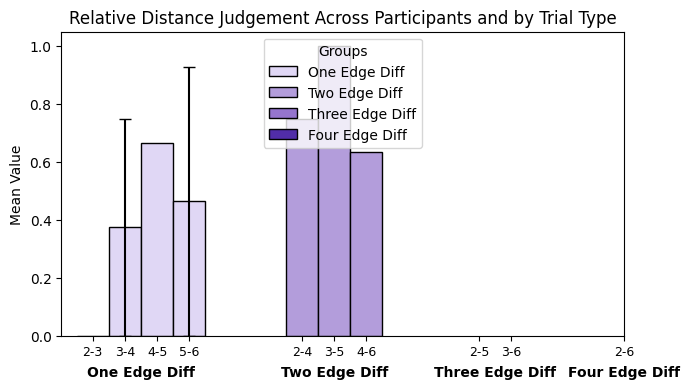

In [5]:
bad_partid = ['5cba50bf114fa5001aac5570','6657584ca6e3645f4a99e753','67e2b86a96de1816df85cefe','5fadeb340e10471fdeb5fbf5']
direct_df = df_flights[df_flights['trial_type']=='directmemory_phase']
direct_df = direct_df.loc[:, ~direct_df.isna().all()]
direct_df = direct_df.drop(columns=['time_elapsed','cumulative_accuracy','weighted_accuracy','missedtrial']).reset_index(drop='index')
direct_df = direct_df.map(lambda x: x.replace('../static/images/US_Cities_List/', '') if isinstance(x, str) else x)
direct_df = direct_df.map(lambda x: x.replace('../static/images/Fictional_Cities_List/', '') if isinstance(x, str) else x)
direct_df = direct_df.map(lambda x: x.replace('../static/images/GW/', '') if isinstance(x, str) else x)

shortest_df = df_flights[df_flights['trial_type']=='shortestpath_phase']
shortest_df = shortest_df.loc[:, ~shortest_df.isna().all()]
shortest_df = shortest_df.drop(columns=['time_elapsed','cumulative_accuracy']).reset_index(drop='index')
shortest_df = shortest_df.map(lambda x: x.replace('../static/images/US_Cities_List/', '') if isinstance(x, str) else x)
shortest_df = shortest_df.map(lambda x: x.replace('../static/images/Fictional_Cities_List/', '') if isinstance(x, str) else x)
shortest_df = shortest_df.map(lambda x: x.replace('../static/images/GW/', '') if isinstance(x, str) else x)

# Step 1: Combine stimulus and stimulus_correct into one long-form df with accuracy
long_direct_df = pd.concat([
    direct_df[['partid', 'stimulus', 'accuracy']].rename(columns={'stimulus': 'city'}),
    direct_df[['partid', 'stimulus_correct', 'accuracy']].rename(columns={'stimulus_correct': 'city'})
])

# Step 2: Group by participant and city, then check if all accuracies were 1.0
city_accuracy = long_direct_df.groupby(['partid', 'city'])['accuracy'].agg(lambda x: (x == 1.0).all()).reset_index()
city_accuracy = city_accuracy[city_accuracy['accuracy']]  # Keep only 100% accurate cities
city_accuracy = city_accuracy.drop(columns='accuracy')     # Just keep partid and city

# Step 3: Filter shortest_df by keeping only rows where both cities were 100% accurate
filtered_shortest_df = shortest_df[
    shortest_df.apply(
        lambda row: (
            (row['partid'], row['stimulus']) in city_accuracy.set_index(['partid', 'city']).index and
            (row['partid'], row['stimulus_correct']) in city_accuracy.set_index(['partid', 'city']).index
        ),
        axis=1
    )
]
grouped_shortest = filtered_shortest_df.groupby(['partid','specific_pairs'])['accuracy'].agg(['mean','count']).reset_index()

twothree = grouped_shortest[grouped_shortest['specific_pairs']=='Two Edge Three Edge']
threefour = grouped_shortest[grouped_shortest['specific_pairs']=='Three Edge Four Edge']
fourfive = grouped_shortest[grouped_shortest['specific_pairs']=='Four Edge Five Edge']
fivesix = grouped_shortest[grouped_shortest['specific_pairs']=='Five Edge Six Edge']

twofour = grouped_shortest[grouped_shortest['specific_pairs']=='Two Edge Four Edge']
threefive = grouped_shortest[grouped_shortest['specific_pairs']=='Three Edge Five Edge']
foursix = grouped_shortest[grouped_shortest['specific_pairs']=='Four Edge Six Edge']

twofive = grouped_shortest[grouped_shortest['specific_pairs']=='Two Edge Five Edge']
threesix = grouped_shortest[grouped_shortest['specific_pairs']=='Three Edge Six Edge']

twosix = grouped_shortest[grouped_shortest['specific_pairs']=='Two Edge Six Edge']

# --- Sample Data ---
group_labels = ['One Edge Diff', 'Two Edge Diff', 'Three Edge Diff', 'Four Edge Diff']

# Generate dummy data
heights = [
    [twothree['mean'].mean(), threefour['mean'].mean(), fourfive['mean'].mean(), fivesix['mean'].mean()],  # One diff
    [twofour['mean'].mean(), threefive['mean'].mean(), foursix['mean'].mean()],       # Two diff
    [twofive['mean'].mean(), threesix['mean'].mean()],            # Three diff
    [twosix['mean'].mean()]                  # Four diff
]

errors = [
    [twothree['mean'].sem(), threefour['mean'].sem(), fourfive['mean'].sem(), fivesix['mean'].sem()],  # One diff
    [twofour['mean'].sem(), threefive['mean'].sem(), foursix['mean'].sem()],       # Two diff
    [twofive['mean'].sem(), threesix['mean'].sem()],            # Three diff
    [twosix['mean'].sem()]                  # Four diff
]

bar_labels = [
    ['2-3', '3-4', '4-5', '5-6'],     # One diff
    ['2-4', '3-5', '4-6'],          # Two diff
    ['2-5', '3-6'],               # Three diff
    ['2-6']                    # Four diff
]

bar_width = 0.2
group_gap = 0.5

fig, ax = plt.subplots(figsize=(7, 4))

x_offset = 0
all_positions = []
all_labels = []
group_centers = []
# Optional: participant-level means
participant_means = shortest_df.groupby(['partid', 'specific_pairs'])['accuracy'].mean().reset_index()

# Then Tukey test on those
# tukey = pairwise_tukeyhsd(endog=participant_means['accuracy'],
#                         groups=participant_means['specific_pairs'],
#                         alpha=0.05)
# print(tukey.summary())
# Define blue color shades (lightest to darkest)
group_colors = ['#e0d7f5', '#b39ddb', '#9575cd', '#512da8']
# group_colors = ['#cce5ff', '#66b3ff', '#1f78b4', '#08306b']  # Adjust or expand as needed

for i, (group, group_err, labels) in enumerate(zip(heights, errors, bar_labels)):
    num_bars = len(group)
    positions = np.arange(num_bars) * bar_width + x_offset
    ax.bar(positions, group, yerr=group_err, capsize=4, width=bar_width,
        edgecolor='black', label=group_labels[i], color=group_colors[i])
    
    # Store positions and labels for x-ticks
    all_positions.extend(positions)
    all_labels.extend(labels)
    
    # Calculate center of group for big group label
    group_centers.append(positions.mean())
    
    # Update x offset for next group
    x_offset = positions[-1] + bar_width + group_gap

# Set small bar labels as x-tick labels
ax.set_xticks(all_positions)
ax.set_xticklabels(all_labels, fontsize=9)

# Add big group labels below
for center, label in zip(group_centers, group_labels):
    ax.text(center, -0.1, label, ha='center', va='top', fontsize=10,
            fontweight='bold', transform=ax.transData)
# --- Formatting ---
ax.legend(title='Groups')
ax.set_ylabel('Mean Value')
ax.set_title(f'Relative Distance Judgement Across Participants and by Trial Type')
plt.tight_layout()
plt.show()

UnboundLocalError: cannot access local variable 'group_colors' where it is not associated with a value

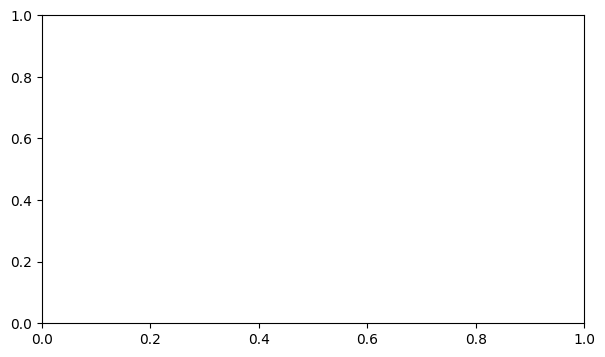

In [14]:
# Relative Distance Judgement Analysis
import matplotlib.pyplot as plt
import numpy as np
def get_relative_distance(df,exp_type):
    shortest_df = df[df['trial_type']=='shortestpath_phase']
    shortest_df = shortest_df.loc[:, ~shortest_df.isna().all()]
    shortest_df = shortest_df.drop(columns=['time_elapsed','cumulative_accuracy']).reset_index(drop='index')
    shortest_df = shortest_df.map(lambda x: x.replace('../static/images/US_Cities_List/', '') if isinstance(x, str) else x)
    shortest_df = shortest_df.map(lambda x: x.replace('../static/images/Fictional_Cities_List/', '') if isinstance(x, str) else x)
    shortest_df = shortest_df.map(lambda x: x.replace('../static/images/GWF/', '') if isinstance(x, str) else x)
    shortest_df = shortest_df[shortest_df['rt']>400]
    shortest_df = shortest_df[shortest_df['rt']<3000]
    shortest_df = shortest_df[~shortest_df['stimulus'].isna()]
    # for id in bad_partid:
    #     shortest_df = shortest_df[shortest_df['partid'] != id]
    grouped_shortest = shortest_df.groupby(['partid','specific_pairs'])['accuracy'].agg(['mean','count']).reset_index()

    twothree = grouped_shortest[grouped_shortest['specific_pairs']=='Two Edge Three Edge']
    threefour = grouped_shortest[grouped_shortest['specific_pairs']=='Three Edge Four Edge']
    fourfive = grouped_shortest[grouped_shortest['specific_pairs']=='Four Edge Five Edge']
    fivesix = grouped_shortest[grouped_shortest['specific_pairs']=='Five Edge Six Edge']

    twofour = grouped_shortest[grouped_shortest['specific_pairs']=='Two Edge Four Edge']
    threefive = grouped_shortest[grouped_shortest['specific_pairs']=='Three Edge Five Edge']
    foursix = grouped_shortest[grouped_shortest['specific_pairs']=='Four Edge Six Edge']

    twofive = grouped_shortest[grouped_shortest['specific_pairs']=='Two Edge Five Edge']
    threesix = grouped_shortest[grouped_shortest['specific_pairs']=='Three Edge Six Edge']

    twosix = grouped_shortest[grouped_shortest['specific_pairs']=='Two Edge Six Edge']

    # --- Sample Data ---
    group_labels = ['One Edge Diff', 'Two Edge Diff', 'Three Edge Diff', 'Four Edge Diff']

    # Generate dummy data
    heights = [
        [twothree['mean'].mean(), threefour['mean'].mean(), fourfive['mean'].mean(), fivesix['mean'].mean()],  # One diff
        [twofour['mean'].mean(), threefive['mean'].mean(), foursix['mean'].mean()],       # Two diff
        [twofive['mean'].mean(), threesix['mean'].mean()],            # Three diff
        [twosix['mean'].mean()]                  # Four diff
    ]

    errors = [
        [twothree['mean'].sem(), threefour['mean'].sem(), fourfive['mean'].sem(), fivesix['mean'].sem()],  # One diff
        [twofour['mean'].sem(), threefive['mean'].sem(), foursix['mean'].sem()],       # Two diff
        [twofive['mean'].sem(), threesix['mean'].sem()],            # Three diff
        [twosix['mean'].sem()]                  # Four diff
    ]

    bar_labels = [
        ['2-3', '3-4', '4-5', '5-6'],     # One diff
        ['2-4', '3-5', '4-6'],          # Two diff
        ['2-5', '3-6'],               # Three diff
        ['2-6']                    # Four diff
    ]

    bar_width = 0.2
    group_gap = 0.5

    fig, ax = plt.subplots(figsize=(7, 4))

    x_offset = 0
    all_positions = []
    all_labels = []
    group_centers = []
    # Optional: participant-level means
    participant_means = shortest_df.groupby(['partid', 'specific_pairs'])['accuracy'].mean().reset_index()

    # Then Tukey test on those
    # tukey = pairwise_tukeyhsd(endog=participant_means['accuracy'],
    #                         groups=participant_means['specific_pairs'],
    #                         alpha=0.05)
    # print(tukey.summary())
    # Define blue color shades (lightest to darkest)
    if exp_type == 'Flights Young':
        group_colors = ['#e0d7f5', '#b39ddb', '#9575cd', '#512da8']
    elif exp_type == 'Replication Young':
        group_colors = ['#cce5ff', '#66b3ff', '#1f78b4', '#08306b']  # Adjust or expand as needed

    if exp_type == 'Flights Old':
        group_colors = ['#e0d7f5', '#b39ddb', '#9575cd', '#512da8']
    elif exp_type == 'Replication Old':
        group_colors = ['#cce5ff', '#66b3ff', '#1f78b4', '#08306b']  # Adjust or expand as needed

    for i, (group, group_err, labels) in enumerate(zip(heights, errors, bar_labels)):
        num_bars = len(group)
        positions = np.arange(num_bars) * bar_width + x_offset
        ax.bar(positions, group, yerr=group_err, capsize=4, width=bar_width,
            edgecolor='black', label=group_labels[i], color=group_colors[i])
        
        # Store positions and labels for x-ticks
        all_positions.extend(positions)
        all_labels.extend(labels)
        
        # Calculate center of group for big group label
        group_centers.append(positions.mean())
        
        # Update x offset for next group
        x_offset = positions[-1] + bar_width + group_gap

    # Set small bar labels as x-tick labels
    ax.set_xticks(all_positions)
    ax.set_xticklabels(all_labels, fontsize=9)

    # Add big group labels below
    for center, label in zip(group_centers, group_labels):
        ax.text(center, -0.1, label, ha='center', va='top', fontsize=10,
                fontweight='bold', transform=ax.transData)
    # --- Formatting ---
    ax.legend(title='Groups')
    ax.set_ylabel('Mean Value')
    ax.set_title(f'Relative Distance Judgement Across Participants and by Trial Type in {exp_type}')
    plt.axhline(y=0.5, color='gray', linestyle='--', linewidth=1)
    plt.tight_layout()
    plt.show()
    return grouped_shortest
flights_grouped_short = get_relative_distance(df_flights,'Flights')

In [18]:
df_flights['condition'].unique()

array([nan, 'One Edge Diff', 'Two Edge Diff', '1'], dtype=object)